In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [3]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            
            # state_one_hot will be an 1-d array of size n, with
            # the element on the index specified by self.state assigned
            # the value of 1
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))

            # output_layer will pump out weights for each action
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer
            )

            # tf.nn.softmax() will give (1, 4) output.
            # 'Squeeze' that output into an 1-d array.
            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            
            # We just need to know the probability assigned to the chosen action.
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

            self.train_op = self.optimizer.minimize(
                self.loss,
                global_step=tf.contrib.framework.get_global_step()
            )
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()

        feed_dict = { 
            self.state: state,
            self.target: target,
            self.action: action
        }

        _, loss = sess.run(
            [self.train_op, self.loss],
            feed_dict
        )

        return loss

In [4]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")
            self.action = tf.placeholder(dtype=tf.int32, name="action")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer
            )

            self.value_estimate = tf.squeeze(self.output_layer)
            
            self.value_estimate_action = tf.gather(self.value_estimate, self.action)

            # TD Error?
            self.loss = tf.squared_difference(self.value_estimate_action, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            self.train_op = self.optimizer.minimize(
                self.loss,
                global_step=tf.contrib.framework.get_global_step()
            )        
    
    def predict(self, state, action=None, sess=None):
        sess = sess or tf.get_default_session()
        
        if action == None:
            return sess.run(self.value_estimate, { self.state: state, self.action: -1 })
        else:
            return sess.run(self.value_estimate_action, { self.state: state, self.action: action })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()

        feed_dict = {
            self.state: state,
            self.target: target,
            self.action: action
        }

        _, loss = sess.run(
            [self.train_op, self.loss],
            feed_dict
        )

        return loss

In [5]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the first action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(
                Transition(
                    state=state, action=action, reward=reward, next_state=next_state, done=done
                )
            )
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # TODO: Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(
                state=state,
                target=estimator_value.predict(state, action),
                action=action
            )
            
            # TODO: Calculate TD Target
            next_action_probs = estimator_policy.predict(next_state)
            next_action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            td_target = reward + discount_factor * estimator_value.predict(next_state, next_action)
            
            # TODO: Update the value estimator
            estimator_value.update(
                state=state,
                # estimator_value will calculate TD Error internally
                # with td_target given
                target=td_target,
                action=action
            )

            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [6]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    stats = actor_critic(env, policy_estimator, value_estimator, 100000)

Step 0 @ Episode 100000/100000 (-100.0)))

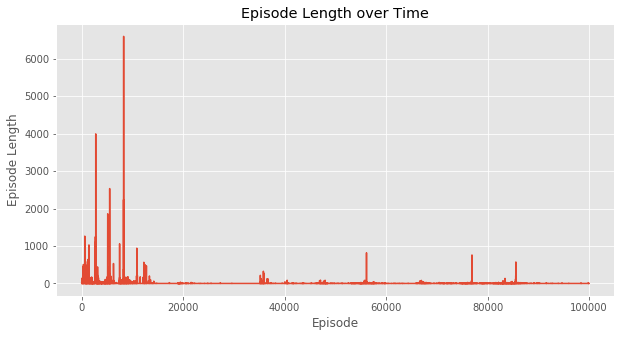

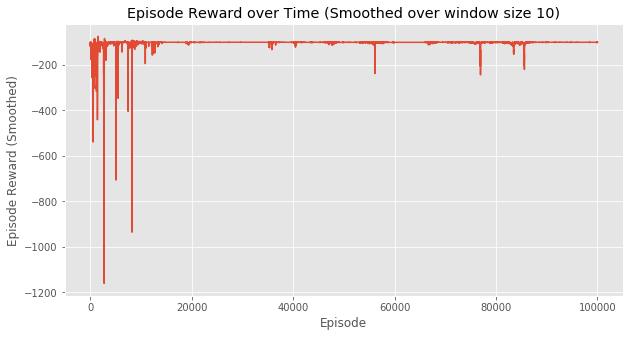

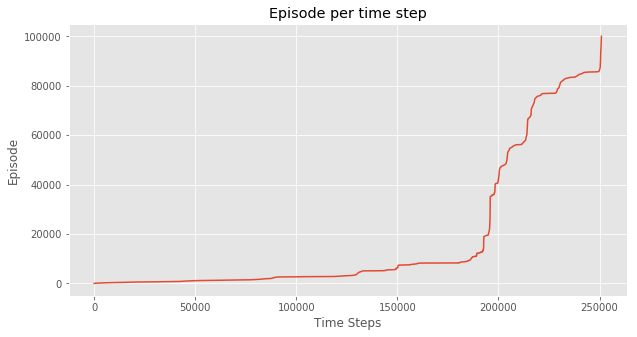

(<matplotlib.figure.Figure at 0x118da3c88>,
 <matplotlib.figure.Figure at 0x1196ec3c8>)

In [7]:
plotting.plot_episode_stats(stats, smoothing_window=10)

In [8]:
for i in range(len(stats.episode_rewards)):
    print('({}, {})'.format(stats.episode_lengths[i], stats.episode_rewards[i]))

(16.0, -116.0)
(2.0, -102.0)
(2.0, -102.0)
(6.0, -106.0)
(5.0, -105.0)
(1.0, -101.0)
(2.0, -102.0)
(3.0, -103.0)
(3.0, -103.0)
(15.0, -115.0)
(43.0, -143.0)
(28.0, -128.0)
(7.0, -107.0)
(18.0, -118.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(18.0, -118.0)
(43.0, -143.0)
(4.0, -104.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(6.0, -106.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(5.0, -105.0)
(6.0, -106.0)
(9.0, -109.0)
(1.0, -101.0)
(23.0, -123.0)
(0.0, -100.0)
(8.0, -108.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(5.0, -105.0)
(0.0, -100.0)
(3.0, -103.0)
(5.0, -105.0)
(8.0, -108.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(25.0, -125.0)
(4.0, -104.0)
(6.0, -106.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(18.0, -118.0)
(19.0, -119.0)
(9.0, -109.0)
(0.0, -100.0)
(16.0, -1

(35.0, -135.0)
(16.0, -116.0)
(25.0, -125.0)
(35.0, -135.0)
(38.0, -138.0)
(41.0, -141.0)
(104.0, -204.0)
(13.0, -113.0)
(45.0, -46.0)
(10.0, -110.0)
(118.0, -119.0)
(11.0, -111.0)
(2.0, -102.0)
(4.0, -104.0)
(55.0, -155.0)
(4.0, -104.0)
(9.0, -109.0)
(38.0, -138.0)
(38.0, -138.0)
(11.0, -111.0)
(3.0, -103.0)
(2.0, -102.0)
(60.0, -61.0)
(0.0, -100.0)
(25.0, -125.0)
(62.0, -63.0)
(0.0, -100.0)
(36.0, -136.0)
(0.0, -100.0)
(6.0, -106.0)
(37.0, -137.0)
(9.0, -109.0)
(58.0, -59.0)
(75.0, -175.0)
(28.0, -128.0)
(4.0, -104.0)
(24.0, -124.0)
(6.0, -106.0)
(2.0, -102.0)
(21.0, -121.0)
(25.0, -125.0)
(51.0, -151.0)
(2.0, -102.0)
(12.0, -112.0)
(0.0, -100.0)
(13.0, -113.0)
(11.0, -111.0)
(10.0, -110.0)
(14.0, -114.0)
(79.0, -179.0)
(11.0, -111.0)
(2.0, -102.0)
(56.0, -156.0)
(62.0, -162.0)
(191.0, -291.0)
(16.0, -116.0)
(83.0, -183.0)
(81.0, -181.0)
(50.0, -150.0)
(53.0, -153.0)
(18.0, -118.0)
(73.0, -173.0)
(33.0, -133.0)
(20.0, -120.0)
(245.0, -345.0)
(4.0, -104.0)
(454.0, -554.0)
(92.0, -192.

(0.0, -100.0)
(7.0, -107.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(33.0, -133.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(6.0, -106.0)
(0.0, -100.0)
(0.0, -100.0)
(11.0, -111.0)
(2.0, -102.0)
(6.0, -106.0)
(1.0, -101.0)
(10.0, -110.0)
(0.0, -100.0)
(4.0, -104.0)
(4.0, -104.0)
(3.0, -103.0)
(11.0, -111.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(1.0, -101.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(4.0, -104.0)
(4.0, -104.0)
(4.0, -104.0)
(3.0, -103.0)
(5.0, -105.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(2.0, -102.0)
(6.0, -106.0)
(0.0, -100.0)
(6.0, -106.0)
(2.0, -102.0)
(10.0, -110.0)
(10.0, -110.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(6.0, -106.0)
(4.0, -104.0)
(8.0, -108.0)
(18.0, -118.0)
(11.0, -111.0)
(0.0, -100.0)
(0.0, -100.0)
(7.0, -107.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(4.0, -104.0)
(6.0, -106.0)
(0.0, -100.0)
(0.0, -100.0

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(3.0, -103.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(3.0, -103.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(2.0, -102.0)
(1.0, -101.0)
(3.0, -103.0)
(1.0, -101.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(4.0, -104.0)
(7.0, -107.0)
(2.0, -102.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(2.0, -102.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(28.0, -128.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(203.0, -204.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(7.0, -107.0)
(0.0, -100.0)
(0.0, -100.0)
(30.0, -130.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1

(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(1.0, -101.0)
(7.0, -107.0)
(2.0, -102.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(4.0, -104.0)
(1.0, -101.0)
(0.0, -100.0)
(10.0, -110.0)
(3.0, -103.0)
(2.0, -102.0)
(12.0, -112.0)
(2.0, -102.0)
(1.0, -101.0)
(2.0, -102.0)
(0.0, -100.0)
(5.0, -105.0)
(1.0, -101.0)
(0.0, -100.0)
(2.0, -102.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(3.0, -103.0)
(1.0, -101.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(6.0, -106.0)
(1.0, -101.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(1.0, -101.0)
(2.0, -102.0)
(12.0, -112.0)
(5.0, -105.0)
(10.0, -110.0)
(10.0, -110.0)
(13.0, -113.0)
(25.0, -125.0)
(10.0, -110.0)
(7.0, -107.0)
(1.0, -101.0)
(2.0, -102.0)
(2.0, -102.0)
(20.0, -120.0)
(1.0, -101.0)
(7.0, -107.0)
(1.0, -101.0)
(10.0, -110.0)
(2.0, -102.0)
(2.0, -102.0)
(7.0, -107.0)
(22.0, -122.0)
(8.0, -108.0)
(16.0, -116.0)
(3.0, -103.0)
(2.0, -1

(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(43.0, -143.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(44.0, -144.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(86.0, -186.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(127.0, -227.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(202.0, -203.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(33.0, -133.0)


(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(502.0, -602.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(62.0, -162.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0,

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(6.0, -106.0)
(1.0, -101.0)
(9.0, -109.0)
(5.0, -105.0)
(3.0, -103.0)
(2.0, -102.0)
(1.0, -101.0)
(4.0, -104.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(2.0, -102.0)
(5.0, -105.0)
(1.0, -101.0)
(4.0, -104.0)
(0.0, -100.0)
(1.0, -101.0)
(11.0, -111.0)
(1.0, -101.0)
(1.0, -101.0)
(2.0, -102.0)
(4.0, -104.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(10.0, -110.0)
(11.0, -111.0)
(0.0, -100.0)
(1.0, -101.0)
(5.0, -105.0)
(0.0, -100.0)
(4.0, -104.0)
(3.0, -103.0)
(25.0, -125.0)
(0.0, -100.0)
(17.0, -117.0)
(9.0, -109.0)
(12.0, -112.0)
(17.0, -117.0)
(4.0, -104.0)
(4.0, -104.0)
(21.0, -121.0)
(4.0, -104.0)
(14.0, -114.0)
(16.0, -116.0)
(3.0, -103.0)
(18.0, -118.0)
(14.0, -114.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(2.0, -102.0)
(9.0, -109.0)
(0.0, -100.0)
(8.0, -108.0)
(0.0, -100.0)
(9.0, -109.0)
(2.0, -102.0)
(13.0, -113.0)
(4.0, -104.0)
(2.0, -102.0)
(3.0, -103.0)
(8.0, -108.0)
(3.0, -103.0)
(2.0, -102.0)
(2.0, -102.0)
(0.0, -100.0)
(17.0, -117.0)
(6.0, 

(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(127.0, -227.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0

(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(4.0, -104.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(43.0, -143.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0,

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(13.0, -113.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0,

(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(15.0, -115.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(8.0, -108.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0,

(0.0, -100.0)
(2.0, -102.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(3.0, -103.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(2.0, -102.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(2.0, -102.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(6.0, -106.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(14.0, -114.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(3.0, -103.0)
(28.0, -128.0)
(0.0, -100.0)
(6.0, -106.0)
(0.0, -100.0)
(8.0, -108.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(11.0, -111.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(5.0, -105.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(6.0, -106.0)
(0.0, -100.0)
(6.0, -106.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(29.0, -129.0)
(3.0, -103.0)
(6.0, -106.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(7.0, -107.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0

(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(1.0, -101.0)
(4.0, -104.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(19.0, -119.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(2.0, -102.0)
(0.0, -100.0)
(6.0, -106.0)
(1.0, -101.0)
(2.0, -102.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(8.0, -108.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0,

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(6.0, -106.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(5.0, -105.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(12.0, -112.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(3.0, -103.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(2.0, -102.0)
(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(5.0, -105.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(7.0, -107.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(9.0, -109.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0,

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(5.0, -105.0)
(0.0, -100.0)
(5.0, -105.0)
(1.0, -101.0)
(1.0, -101.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(10.0, -110.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0,

(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(2.0, -102.0)
(0.0, -100.0)
(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(3.0, -103.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(6.0, -106.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(5.0, -105.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(3.0, -103.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(5.0, -105.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(2.0, -102.0)
(3.0, -103.0)
(1.0, -101.0)
(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(3.0, -103.0)
(0.0, -100.0)
(0.0, -100.0)
(9.0, -109.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(2.0, -102.0)
(3.0, -103.0)
(0.0, -100.0)
(5.0, -105.0)
(1.0, -101.0)
(1.0, -101.0)
(2.0, -102.0)
(4.0, -104.0)
(7.0, -107.0)
(14.0, -114.0)
(8.0, -108.0)
(1.0, -101.0)
(1.0, -101.0)
(4.0, -104.0)
(2.0, -102.0)
(0.0, -100.0)
(6.0, -106.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(6.0, -106.0)
(5.0, -105.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(7.0, -107.0)
(1.0, -101.0)
(3.0, -103.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(10.0, -110.0)
(4.0, -104.0)
(0.0, -100.0)
(1.0, -101.0)
(2.0, -102.0)
(12.0, -112.0)
(5.0, -105.0)
(5.0, -105.0)
(7.0, -107.0)
(2.0, -102.0)
(2.0, -102.0)
(4.0, -104.0)
(13.0, -113.0)
(10.0, -110.0)
(5.0, -105.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(6.0, -106.0)
(0.0, -100.0)
(

(4.0, -104.0)
(7.0, -107.0)
(2.0, -102.0)
(9.0, -109.0)
(7.0, -107.0)
(0.0, -100.0)
(2.0, -102.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(2.0, -102.0)
(1.0, -101.0)
(0.0, -100.0)
(1.0, -101.0)
(4.0, -104.0)
(1.0, -101.0)
(3.0, -103.0)
(2.0, -102.0)
(6.0, -106.0)
(2.0, -102.0)
(2.0, -102.0)
(2.0, -102.0)
(3.0, -103.0)
(8.0, -108.0)
(0.0, -100.0)
(4.0, -104.0)
(7.0, -107.0)
(1.0, -101.0)
(6.0, -106.0)
(3.0, -103.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(2.0, -102.0)
(4.0, -104.0)
(6.0, -106.0)
(0.0, -100.0)
(4.0, -104.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(7.0, -107.0)
(0.0, -100.0)
(9.0, -109.0)
(0.0, -100.0)
(5.0, -105.0)
(1.0, -101.0)
(5.0, -105.0)
(0.0, -100.0)
(3.0, -103.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(2.0, -102.0)
(0.0, -100.0)
(9.0, -109.0)
(2.0, -102.0)
(3.0, -103.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(3.0, -103.0)
(2.0, -102.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(10.0, -110.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0,

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, 

(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(1.0, -101.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, -100.0)
(0.0, 